## Avaliação em holdouts - Amazon Books

Interactions in the 'Amazon Books' dataset are well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 2052 users of 16238 (12.637%) occurr in 100% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonbooks_dump/3rd_sampled_amazon_books.csv')
dataset_name = 'Amazon_Books'
user_col = 'user_id'
item_col = 'item_id'

In [32]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((286130, 5), 121060, 209592)

In [33]:
data[['user_id', 'item_id']].duplicated().sum()

988

In [6]:
data.head()

,user_id,item_id,timestamp,date,week
0,1493515292,A37V075RLK14A0,1388534400,2014-01-01,1
1,0312352565,A13Q5H80RKIS1B,1388534400,2014-01-01,1
2,0307914208,A15LTMXCREMY4M,1388534400,2014-01-01,1
3,1477817158,A2BZBUV6T8MA6X,1388534400,2014-01-01,1
4,1893910466,A2LNTWNRU7NP06,1388534400,2014-01-01,1


In [7]:
data.tail()

,user_id,item_id,timestamp,date,week
286125,1493707485,A2DURVJUI7JKDT,1390089600,2014-01-19,3
286126,1442498374,A1QM3DJC5D8NIT,1390089600,2014-01-19,3
286127,1466381213,A1TZLPSHDV6PXW,1390089600,2014-01-19,3
286128,1936220687,APEW4NQ2BUHKU,1390089600,2014-01-19,3
286129,1250005299,A1TZLPSHDV6PXW,1390089600,2014-01-19,3


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286130 entries, 0 to 286129
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    286130 non-null  object
 1   item_id    286130 non-null  object
 2   timestamp  286130 non-null  int64 
 3   date       286130 non-null  object
 4   week       286130 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.9+ MB


### Convert timestamp

In [9]:
%%time 
# 5s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

CPU times: user 2.18 s, sys: 17.3 ms, total: 2.19 s
Wall time: 2.3 s


In [10]:
data.head()

,user_id,item_id,timestamp,date,week
0,1493515292,A37V075RLK14A0,1388534400,2014-01-01,1
1,0312352565,A13Q5H80RKIS1B,1388534400,2014-01-01,1
2,0307914208,A15LTMXCREMY4M,1388534400,2014-01-01,1
3,1477817158,A2BZBUV6T8MA6X,1388534400,2014-01-01,1
4,1893910466,A2LNTWNRU7NP06,1388534400,2014-01-01,1


CPU times: user 108 ms, sys: 11.8 ms, total: 120 ms
Wall time: 119 ms


Text(0.5, 1.0, 'interactions per week')

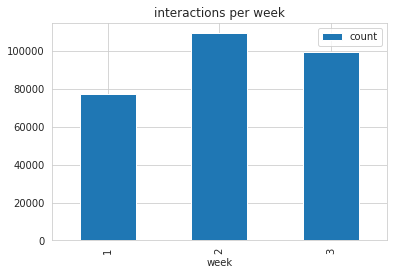

In [11]:
%%time
# 198ms
interactions_per_week = data.groupby(by=['week']).count().iloc[:, 0]
interactions_per_week.name = 'count'
interactions_per_week=interactions_per_week.reset_index()
_ = interactions_per_week.copy()
# _['date'] = _['date'].dt.date
_.groupby('week').sum().plot(kind='bar')
plt.title('interactions per week')

___
## Get intervals and Frequent users (threshold = 0.8)

time intervals

In [12]:
# user_presence_df = pd.read_csv('output/amazonbooks_dump/3rd_sample_user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazonbooks_dump/3rd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonbooks_dump/3rd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [13]:
data.shape

(286130, 5)

In [14]:
%%time
# 1min 26s
buckets, holdouts = getBucketsHoldouts(
    data=data, # data[ data['week'] == 1 ].loc[:20000],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(), #frequent_users_month, # to use every user in holdout: data['user_id'].unique()
    interval_type='W',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 105
common interactions between holdout 2 and all buckets: 149
common interactions between holdout 3 and all buckets: 133
Converting to ImplicitData. . .
Done!
CPU times: user 48min 14s, sys: 987 ms, total: 48min 15s
Wall time: 49min 13s


In [15]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

286130

In [16]:
joblib.dump(buckets, 'output/amazonbooks_dump/3rd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonbooks_dump/3rd_sample_holdouts.joblib')

['output/amazonbooks_dump/3rd_sample_holdouts.joblib']

### ISGD

In [17]:
buckets = joblib.load('output/amazonbooks_dump/3rd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonbooks_dump/3rd_sample_holdouts.joblib')

Hyperparameters

In [18]:
# import itertools
# def grid_search(model, stream, random_seed = 10, interleaved=10):    
#     num_factors = [100, 150, 200]
#     num_iter = [2, 5, 8]
#     learn_rate = [0.1, 0.25, 0.5]
#     regularization = [0.3, 0.4, 0.5]
#     num_nodes = [4, 8, 16]
#     grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
#     grid = list(itertools.product(*grid))
#     results = []
#     for i, hp in enumerate(grid):
#         if not ((i*100)/len(grid))%5:
#             print(((i*100)/len(grid)), '%')
#         empty_stream = ImplicitData([], [])
#         nf, ni, lr, reg, nn = hp
#         m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
#         e = EvalPrequential(m, stream, metrics = ["Recall@20"])
#         result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
#         results.append( np.mean(result['Recall@20']) )
#     return grid, results    
# prop = 0.1
# hp_sample = data.iloc[:round( data.shape[0]*prop )]
# stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    

# # %%time
# # 6h 25min 45s
# grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
# len(grid), len(results), max(results)


In [19]:
# define hyperparameters (SAME AS LASTFM)
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [20]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [21]:
%%time
# 1h 42min 35s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 24.1 µs


In [22]:
%%time
# 14 min 40 s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 5759
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 10978
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 2818
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 1d 13h 15s, sys: 1d 15h 1min 47s, total: 3d 4h 2min 2s
Wall time: 1d 4min 49s


In [23]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD results.csv', index=False)

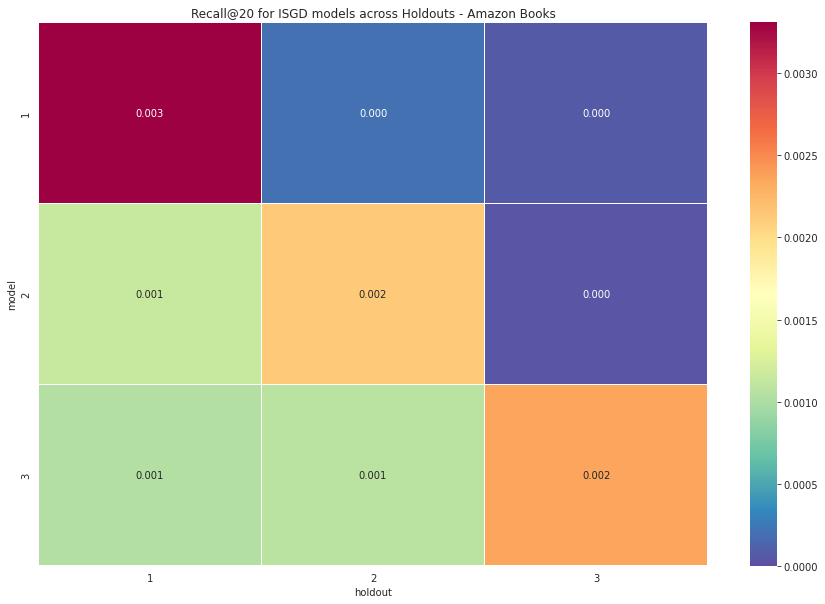

In [31]:
recall_heatmap(df, 
               round_point=3,
               title='Recall@20 for ISGD models across Holdouts - Amazon Books',
               filepath='images/heatmaps/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [25]:
arecall = avg_recall(df)
arecall

0.002599560737661227

In [26]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.002172788411795137, -0.0016574361104556216], -0.0019151122611253794)

In [27]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.00010273918004826423

In [28]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD eval time.joblib')

['output/amazonbooks_dump/3rd_sample_amazon_books month_bucket ISGD eval time.joblib']